In [81]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>''')

In [82]:
HTML('''
<style>
    .yourDiv {position: fixed;top: 100px; left: 10px; 
              background: transparent;
              height: 100%;
              width: 175px; 
              padding: 10px; 
              z-index: 10000}
</style>
<script>
function showthis(url) {
	window.open(url, "pres", 
                "toolbar=yes,scrollbars=yes,resizable=yes,top=10,left=400,width=500,height=500");
	return(false);
}
</script>

<div class=yourDiv id=media-mobile>
    <h4>MENU</h4><br>
    <a href=#Data>1. Data</a><br>
    <a href=#FoodFeedOtherAcross>2. Across Farm Sizes</a><br>
    <a href=#FoodFeedOtherWithin>3. Within Farm Sizes</a><br>
    <a href=#GlobalEstimates>3. Global Estimates</a><br><br>

    <a href=#Top>Top</a><br>
    <a href="javascript:code_toggle()">Toggle Code On/Off</a><br>
    <a href=#LeftOff>Left Off Here</a><br>
    
    <h4>PROJECT NOTEBOOKS</h4><br>
    <a href='../Project_Overview'>Project Overview</a><br>
    <a href='../Data_Coverage'>Data Coverage</a><br>
    <a href='../General_Results'>General Results</a><br>
    <a href='../Global_Estimate'>Global Estimates</a><br>
    <a href='../Crop_Diversity'>Crop Diversity</a><br>
    <a href='../Sensitivity_Analyses'>Sensitivity Analyses</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/'>Site Index</a><br>
</div>
''')

<a name="Top"></a>
<center><h1>General Results</h1>

In [83]:
# *To get dynamic results in this paragraph,
# Uncomment this code block, set Jupyter to markdown, run entire notebook, rerun this codeblock.
# Output of this was pasted into the written description below.*<br><br>

# This page overviews our general results:

# - In our sample of {{number_countries}} countries, farms < 2 ha produce {{under_two}}% of the total food supply (global estimate of between {{under2_low}}% to {{under2_high}}% via bootstrap sampling). This smallest farm size class was the greatest producer of food compared to all other classes.<br><br>

# - Farms < 2ha were also the farm size class contributing to the largest amount of food waste (post-harvest loss, not consumer based food waste); these farms contribute to {{under_two_waste_across}}% of the total food waste in our dataset. However, this is mainly because this farm size group significantly contributes to the total crop production. <br><br>

# - This study also measures what percentage of each farm size class's crop production goes towards food, feed, processing, seed, waste, or other. Smallholders have the greatest percentage of their crop production allocated towards food versus all other farm size classes. {{under_two_food}}% of crop production on farms < 2 ha goes towards food, while {{under_two_feed}}% goes towards feed and {{under_two_waste}}% is wasted (post-harvest loss). The remainder either goes towards processing, seed, or other. The largest farm class, farms > 1000 ha, had the most amount of food waste, as {{over_thous_waste_within}}% of their crop production is wasted. This may be due to this largest farm size class has the greatest percentage of their production going towards processing.<br><br>

# - For more information on the analysis of crop diversity in our study, please see [this notebook](../Crop_Diversity); the general analysis is detailed below.

This page overviews our general results:<br><br>

- In our sample of 55 countries, farms < 2 ha produce 31.7% of the total food supply (global estimate of between 29.94% to 33.98% via bootstrap sampling). This smallest farm size class was the greatest producer of food compared to all other classes.<br><br>

- Farms < 2 ha were also the farm size class contributing to the largest amount of food waste (post-harvest loss, not consumer based food waste); these farms contribute to 28.06% of the total food waste in our dataset. However, this is mainly because this farm size group significantly contributes to the total crop production.<br><br>

- This study also measures what percentage of each farm size class's crop production goes towards food, feed, processing, seed, waste, or other. Smallholders have the greatest percentage of their crop production allocated towards food versus all other farm size classes. 57% of crop production on farms < 2 ha goes towards food, while 13% goes towards feed and 4% is wasted (post-harvest loss). The remainder either goes towards processing, seed, or other. The largest farm class, farms > 1000 ha, had the most amount of food waste, as 7.5% of their crop production is wasted. This may be due to this largest farm size class has the greatest percentage of their production going towards processing.<br><br>

- For more information on the analysis of crop diversity in our study, please see [this notebook](../Crop_Diversity).

In [84]:
import warnings
warnings.filterwarnings('ignore')
import subprocess
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
from matplotlib import colors
import copy
from collections import OrderedDict
from pivottablejs import pivot_ui  # may have to use: python setup.py install --user
import scipy.stats as st
import statsmodels.stats.api as sms
from scipy.stats import linregress
import matplotlib.patches as patches
from matplotlib import lines
from matplotlib.colors import ListedColormap
from sklearn import linear_model
# import statsmodels.api as sm
import statsmodels.formula.api as smf
from scikits import bootstrap  # may have to pip install *.zip
    
plt.style.use('seaborn-muted')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

%matplotlib inline

In [85]:
def read_data_init(path, use_predicted=False):
    
    data = pd.read_csv(path, low_memory=False)
    data['fs_class_max'] = np.where(data['fs_class_max'].isnull(), 10000, data['fs_class_max'])
    
    if use_predicted is False:
        
        data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                    bins=[0, 1, 2, 5, 10, 20, 50,
                                          100, 200, 500, 1000, 100000])
    else:
        
        # Predicted data is available with these breaks only due to sample sizes per model
        data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                    bins=[0, 2, 5, 10, 20, 50, 100, 100000])                                
    data = data.replace(0.0, np.nan)  # there were many zero values
    
    return data

In [86]:
def join_predicted(path_data_orig, use_predicted=True, predict_how='means'):
    
    data_orig = read_data_init(path_data_orig, use_predicted=use_predicted)
    
    if predict_how is 'uppers':
        try:
            PATH_predicted = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/predicted_data_uppers.csv'
        except:
            PATH_predicted = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/predicted_data_uppers.csv'
            
    elif predict_how is 'lowers':
        try:
            PATH_predicted = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/predicted_data_lowers.csv'
        except:
            PATH_predicted = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/predicted_data_lowers.csv'

    elif predict_how is 'means':
#         try:
#             PATH_predicted = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/predicted_data_means.csv'
#         except:
        PATH_predicted = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/predicted_data_means.csv'
            
    predicted = pd.read_csv(PATH_predicted)
    
    predicted['shpID'] = predicted['NAME_0']
    predicted['Item_Code'] = 99999
    # predicted = predicted.loc[predicted['NAME_0'] != 'China']  # To see effects of China, or India uncomment and change accordingly

    data_orig = pd.merge(data_orig, 
                         predicted, 
                         on=['NAME_0',
                             'Farm_Sizes', 
                             'shpID', 
                             'Item_Code', 
                             'production_Food_kcal',
                             'production_Feed_kcal',
                             'production_Seed_kcal',
                             'production_Waste_kcal',
                             'production_Processing_kcal',
                             'production_Other_kcal'],
                         how='outer')
    
    data_orig['Farm_Sizes'] = pd.Categorical(data_orig['Farm_Sizes'], 
                                             categories=['(0, 2]', '(2, 5]', '(5, 10]', 
                                                         '(10, 20]', '(20, 50]', '(50, 100]', 
                                                         '(100, 100000]'],
                                             ordered=True)
    return data_orig

In [87]:
def clean_data(data):

    global variables
    variables = OrderedDict([('Farm_Sizes', 'Farm_Sizes'),
                             ('production_Food_kcal', 'Food'),
                             ('production_Feed_kcal', 'Feed'),
                             ('production_Seed_kcal', 'Seed'),
                             ('production_Waste_kcal', 'Waste'),
                             ('production_Processing_kcal', 'Processing'),
                             ('production_Other_kcal', 'Other')])

    data = data.loc[:, variables.keys()]
    data.columns = variables.values()

    return data

In [88]:
def piv(data, func=np.nansum):

    pivot = pd.pivot_table(data,
                           index=['Farm_Sizes'],
                           values=variables.values()[1:],
                           aggfunc=func)

    return pivot

In [89]:
def perc(data, how='within'):

    if how is 'within':

        pivot = piv(data)
        pivot = pivot.transpose()

        for variable in pivot.columns:
            pivot[variable] = pivot[variable] / pivot[variable].sum()

        return pivot.transpose()


    elif how is 'cumsum':

        pivot = piv(data)

        for variable in pivot.columns:
            pivot[variable] = pivot[variable] / pivot[variable].sum()

        pivot = pivot.cumsum(axis=0)

        return pivot


    elif how is 'across':

        pivot = piv(data)

        for variable in pivot.columns:
            pivot[variable] = pivot[variable] / pivot[variable].sum()

        return pivot.transpose()

    else:

        print 'Require how argument'

In [90]:
# To incorporate predicted values set to True. To only use directly measured dataset set to False
    
use_predicted = False

PATH = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'
# PATH = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'    

if use_predicted is True:

    data_orig = join_predicted(PATH, 
                               use_predicted=True, 
                               predict_how='means')
         
else:
    
    data_orig = read_data_init(PATH, use_predicted=use_predicted)

df = clean_data(data_orig)

In [91]:
df_within = perc(df, how='within')
df_across = perc(df, how='across')
df_cumsum = perc(df, how='cumsum')
df_across_prod = pd.DataFrame(df_across.mean(), columns=['All']).reset_index()
df_raw = piv(df)

In [92]:
tmp1 = df_within.copy()
tmp1['Type'] = 'Within'

tmp2 = df_across.copy()
tmp2 = tmp2.transpose()
tmp2['Type'] = 'Across'

tmp3 = df_cumsum.copy()
tmp3['Type'] = 'Cumsum'

tmp4 = df_raw.copy()
tmp4['Type'] = 'Raw'

tmp5 = df_across_prod.copy()
tmp5['Type'] = 'All'

tmp = pd.concat([tmp1, tmp2, tmp3, tmp4])
tmp = tmp.reset_index()
# tmp = pd.merge(tmp, tmp5, on=['Farm_Sizes', 'Type'], how='outer')
tmp['Farm_Sizes'] = tmp['Farm_Sizes'].astype(str).str.replace('(', '')
tmp['Farm_Sizes'] = tmp['Farm_Sizes'].astype(str).str.replace(']', '')

In [93]:
if use_predicted is False:

    under_two = round(100 * df_cumsum.iloc[1,1], 1)
    under_fifty = round(100 * df_cumsum.iloc[5,1], 1)
    onehund_twohund = round(100 * (df_across.iloc[1, 7]), 1)

    one_food = round(100 * df_within.iloc[0,1], 1)
    one_waste = round(100 * df_within.iloc[0,5], 1)
    two_food = round(100 * df_within.iloc[1,1], 1)
    two_waste = round(100 * df_within.iloc[1,5], 1)
    one_feed =  round(100 * df_within.iloc[0,0], 1)
    two_feed =  round(100 * df_within.iloc[1,0], 1)

    tmp_txt = data_orig.query("production_Food == production_Food")
    number_countries = number_countries = len(tmp_txt.NAME_0.unique())
    number_records = len(tmp_txt)
    under_two_food = int(round((one_food + two_food) / 2, 0))
    under_two_waste = int(round((one_waste + two_waste) / 2, 0))
    under_two_feed = int(round((one_feed + two_feed) / 2, 0))

    under_two_waste_across = round(100 * df_cumsum.iloc[1, -1], 2)
    under_two_food_within = round(100 * ((df_within.iloc[0, 1] + df_within.iloc[1, 1]) / 2), 2)
    over_thous_waste_within = round(100 * df_within.iloc[-1, -1], 2)
    
    area = pd.pivot_table(data_orig, index='Farm_Sizes', values='Area_fix', aggfunc=np.nansum).reset_index()
    area['area_perc'] = area['Area_fix'] / area['Area_fix'].sum()
    
else:
    pass

<a name="Data"></a>
<h2>Data</h2><br>

For an overview of the data, see the [data coverage notebook](../Data_Coverage).<br><br>
Click the table to interactively explore the data. Use 'type' to change whether you are looking at the percentage of crop produced for each category 'within' a farm size group, 'across' groups, via a 'cumulative' percentage across groups, or raw kcal produced. Use the dropdown labeled 'Food' to recalculate based on another production category. 

In [94]:
# pivot_ui(tmp, 
#          rows=['Farm_Sizes'], 
#          cols=['Type'], 
#          aggregatorName='Sum', 
#          vals=['Food'],
#          rendererName='Col Heatmap', 
#          colOrder= "value_a_to_z")

# Enable for pivot table interactivitity within this Jupyter notebook
# Here's a nice example of how to change the html output file for prettier output when in html: 
# https://pivottable.js.org/examples/montreal_2014.html

In [95]:
# gen_path = '/Users/Vinny_Ricciardi/Documents/Scripts/Python/Projects/FarmSize_Global/virtualenvironment/app_/JupyterSite/'
gen_path = '/home/vinny_ricciardi/Documents/Scripts/Python/Projects/FarmSize_Global/virtualenvironment/app_/JupyterSite/'
html_path = gen_path + 'Notebooks/pivottablejs.html'
img_path = gen_path + 'Html/pivot_pic.png'

subprocess.call("wkhtmltoimage {} {}".format(html_path, img_path), shell=True);

In [96]:
%%html
<a href="../pivottablejs" 
rel="some text">
<img src=../pivot_pic.png 
    alt="Drawing" style="width: 700px;"/>
    

<a name="FoodFeedOtherAcross"></a>
<h2>Food Feed Other by Farm Size</h2><br>

In [97]:
t = round(100 * df_across.iloc[1,-2], 1)

This plot shows the percentage that each farm size contributes to each category (e.g., food, feed, other, etc.). For example, farms between 500 to 1000 ha produce {{round(100 * df_across.iloc[1,-2], 1)}}% of the total food supply in our sample.

In [98]:
def plot_stacked_bar(data, how='within', fig_=True, ax=None, use_predicted=use_predicted):

    txt1 = ['Food', 'Feed', 'Processing', 'Seed', 'Waste', 'Other']
    
    if use_predicted is False:

        txt2 = ['< 1', '1 to 2', '2 to 5', '5 to 10', '10 to 20',
                '20 to 50', '50 to 100', '100 to 200', '200 to 500',
                '500 to 1000', '> 1000']
        txt3 = ['< 1', '2 to 5', '10 to 20', '50 to 100', '200 to 500', '> 1000']

    else:
        
        txt2 = ['< 2', '2 to 5', '5 to 10', '10 to 20',
                '20 to 50', '50 to 100', '> 100']
        txt3 = ['< 2', '10 to 20', '50 to 100', '> 100']

    
    if how is 'within':

        legend_txts = copy.copy(txt1)
        labels_txts = copy.copy(txt2)
        cmap = ListedColormap(sns.color_palette('muted', n_colors=6).as_hex())
        kind = 'bar'
        data = data.loc[:, txt1]

    elif how is 'across':

        legend_txts = copy.copy(txt2)
        labels_txts = copy.copy(txt1)
        cmap = ListedColormap(sns.color_palette('BuPu', n_colors=11).as_hex())
        kind = 'bar'
        data = data.transpose().loc[:, txt1].transpose()

    elif how is 'cumsum':

        legend_txts = copy.copy(txt1)
        labels_txts = copy.copy(txt3)
        cmap = ListedColormap(sns.color_palette('muted', n_colors=6).as_hex())
        kind = 'area'
        data = data.loc[:, txt1]
    
    else:
        pass
    
    if fig_ is True:
        
        fig = plt.figure(figsize=[10, 5], facecolor='white')
        ax = fig.add_subplot(111)
    
    else:
        pass
    
    data = 100 * data 
    data.plot(kind=kind,
              stacked=True,
              cmap=cmap,
              alpha=0.9,
              linewidth=0,
              grid=False,
              ax=ax)
    
    # Axis main
#     ax.set_axis_bgcolor("#ffffff")
    ax.set_clip_on(False)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Legend
    legend_txts_r = copy.deepcopy(legend_txts)
    legend_txts_r.reverse()
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[::-1], labels[::-1],
                       loc='center left',
                       frameon=1,
                       bbox_to_anchor=(1, 0.5))

    for i in xrange(len(legend_txts_r)):
        legend.get_texts()[i].set_text(legend_txts_r[i])

    frame = legend.get_frame()
    frame.set_color('white')

    # Axis particulars
    ax.set_xticklabels(labels_txts)
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if how is 'within':
        ax.set_xlabel('\nFarm Sizes (ha)', fontsize=12)
        ax.set_ylabel('Percentage\n', fontsize=12)
        ax.set_ylim([0, 100])
        ax.set_title('Type of production per farm size\n', fontsize=12)

    elif how is 'across':
        ax.set_xlabel('\nCategory', fontsize=12)
        ax.set_ylabel('Percentage\n', fontsize=12)
        ax.set_ylim([0, 100])
        ax.set_title('Type of production across farm size\n', fontsize=12)
        
    elif how is 'cumsum':
        ax.set_xlabel('\nFarm Sizes (ha)', fontsize=12)
        ax.set_ylabel('Percentage\n', fontsize=12)
        ax.set_title('Type of production per farm size: Cumulative\n', fontsize=12)
    
#     plt.savefig('/Users/Vinny_Ricciardi/Desktop/ffo_across.png', dpi=1000, bbox_inches='tight')
    if fig_ is True:
        return plt.show()

    else:
        return ax

In [99]:
def factor_plot(data, id_var='Farm_Sizes', use_predicted=use_predicted):
    
    data = pd.melt(data, id_vars='Farm_Sizes')
    data = data.loc[data['value'] > 0.5] 
    data['log'] = np.log(data['value'])
    
    if use_predicted is False:

        fs_order = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
                    '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
                    '(500, 1000]', '(1000, 100000]']
    
    else: 
        
        fs_order = ['(0, 2]', '(2, 5]', '(5, 10]', 
                    '(10, 20]', '(20, 50]', '(50, 100]', '(100, 100000]']


    if id_var is 'Farm_Sizes':
        
        col = 'variable'
        x = 'Farm_Sizes'
        y = 'log'
        order = fs_order

    else:
        
        data = data.sort_values('Farm_Sizes')
        data['Farm_Sizes'] = pd.Categorical(data['Farm_Sizes'], fs_order)
        data = data.sort_values('Farm_Sizes')
        col = 'Farm_Sizes'
        x = 'variable'
        y = 'log'
        order = None

    g = sns.factorplot(x=x, y=y,
                       col=col, 
                       data=data,
                       kind='box',
                       col_wrap=4,
                       color='#55a868',
                       fliersize=1,
                       aspect = 1,
                       order=order)

    g.fig.subplots_adjust(wspace=0.2, hspace=0.3)

    titles = data.variable.unique()
    
    fs_txt = ['< 1', '1 to 2', '2 to 5', '5 to 10', '10 to 20',
              '20 to 50', '50 to 100', '100 to 200', '200 to 500',
              '500 to 1000', '> 1000']
    
    if id_var is 'Farm_Sizes':
        
        for ax, title in zip(g.axes.flat, titles):
            
            ax.set_title(title)
            ax.set_ylabel('Production \n ln (kcal)')
            ax.set_xticklabels(fs_txt)
            ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
            ax.set_xlabel('\nFarm Sizes (ha)')
        
    else:
        
        for ax, title in zip(g.axes.flat, fs_txt):
            
            ax.set_title(title)
            ax.set_ylabel('Production \n ln (kcal)')
            ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
            ax.set_xlabel('\nPoduction Category')

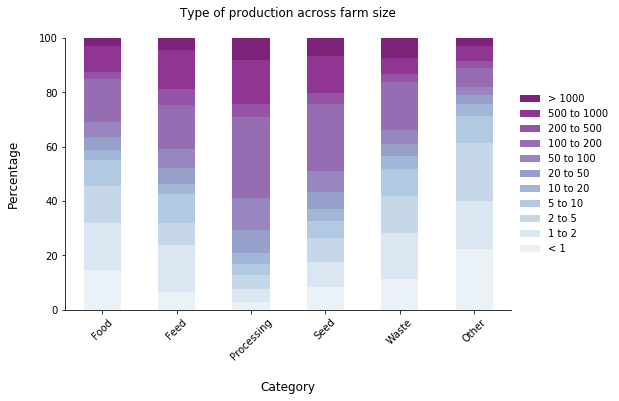

In [100]:
plot_stacked_bar(df_across, how='across', fig_=True)

This plot also shows the percentage that each farm size contributes to each category but in cumulative percentages. For example, farms under 2 ha produce {{under_two}}% of the total food supply in our sample and farms 50 ha and under produce {{under_fifty}}% of the total food supply in our sample. Again, here is a [link](../pivottablejs) to an interactive pivot table so you can explore the data in more detail.

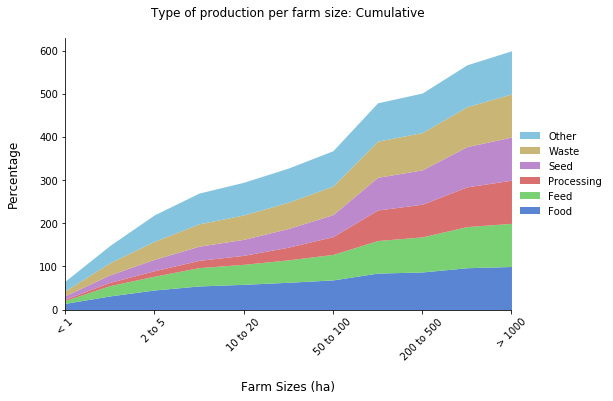

In [101]:
plot_stacked_bar(df_cumsum, how='cumsum', fig_=True)

In order to better understand whether there are differences between the farm size groups, these box plots show the total amount of crops produced (in logged kcal for standardization). Across all production categories (e.g., food, feed, other, etc.) there are no visual differences in the means and confidence intervals. But, there are many of outliers in each plot that indicate high variance.

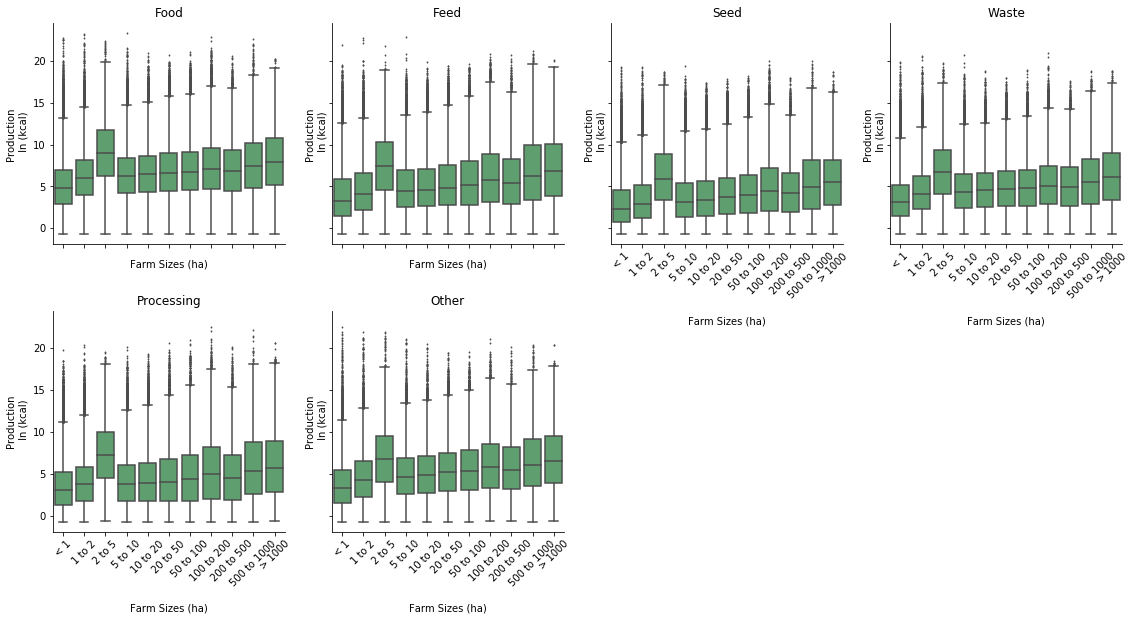

In [102]:
factor_plot(df, id_var='Farm_Sizes')

Since many of the plots have large variance and skewness, here are density plots comparing farm size classes per each category. We can see that the largest farm size group has different distributions from the remaining groups.

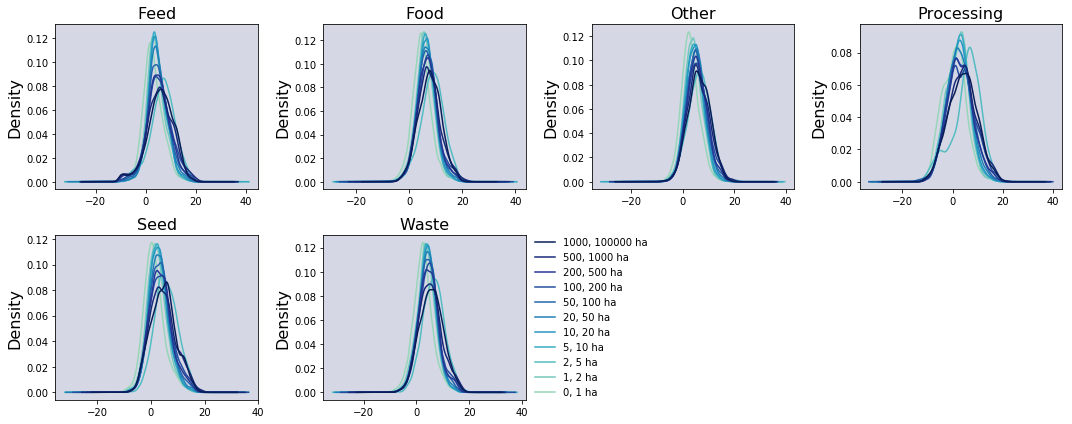

In [103]:
colors_ = ['#97d6b9',
           '#73c8bd',
           '#52bcc2',
           '#37acc3',
           '#2498c1',
           '#1f80b8',
           '#2165ab',
           '#234da0',
           '#253795',
           '#172978',
           '#081d58']

tmp = df.copy()
tmp = pd.melt(tmp, id_vars='Farm_Sizes')
tmp = tmp.dropna()
cols = np.sort(tmp['variable'].unique())

if use_predicted is False:
    fs = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
          '(10, 20]', '(20, 50]', '(50, 100]', 
          '(100, 200]', '(200, 500]', '(500, 1000]', 
          '(1000, 100000]']

else:
    fs = ['(0, 2]', '(2, 5]', '(5, 10]', 
          '(10, 20]', '(20, 50]', '(50, 100]', 
          '(100, 100000]']


fig = plt.figure(figsize=[15, 6])

for j in xrange(len(cols)):
    
    ax = fig.add_subplot(2, 4, j+1)
    ax.set_axis_bgcolor("#d6d7e5")
    ax.grid(alpha=0.0)

    tmp1 = tmp.loc[tmp['variable'] == cols[j]]

    for i in xrange(len(fs)):

        tmp2 = tmp1.loc[tmp1['Farm_Sizes'] == fs[i]]
        np.log(tmp2['value']).plot(kind='kde', 
                                   label=fs[i][1:-1] + ' ha',
                                   color=colors_[i],
                                   ax=ax)
        
    ax.set_title(cols[j], fontsize=16)
    ax.set_ylabel('Density', fontsize=16)
    
legend = ax.legend(frameon=True, fontsize=12)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::-1], labels[::-1],
                   loc='center left',
                   frameon=1,
                   bbox_to_anchor=(1, 0.5))
frame = legend.get_frame()
frame.set_color('#ffffff')

plt.tight_layout()
plt.show()

Since our sample is very large ({{number_countries}} countries which comprise of {{number_records}} total records due to subnational units and crop types) we cannot use p-values to determine significance between the amount of production by varying farm sizes.<br><br>
To circumvent the large dataset issue, the effect size was used to determine differences between farm sizes rather than statistical significance. Cohen's d was calculated via taking the (mean of farmsize 1 - mean of farmsize 2) / (standard deviation of farmsize 1) then taking the absolute value. The relative significance was calculated by thresholds according to [Sullivan and Feinn 2012](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3444174/).

Where the Cohen d's effect size values correspond to percent non-overlapping observations, as in:


| **Relative Size** | **Effect Size**| **Percentile**| **% of Non-overlap**|
|---------------	|:-------------:|:-----------:	|:-------------------:	|
|               	|      0      	|     50    	|         0         	|
| Small         	|     0.2     	|     58    	|         15        	|
| Medium        	|     0.5     	|     69    	|         33        	|
| Large         	|     0.8     	|     79    	|         47        	|
|               	|     1.0     	|     84    	|         55        	|
|               	|     1.5     	|     93    	|         71        	|
|               	|     2.0     	|     97    	|         81        	|

In [104]:
def cohens_d(data1, data2, how='within'):

    cols = data1.columns
    check = []
    
    for i in xrange(0, len(cols)):
        
        for j in xrange(1, len(cols)):
            
            col_name = str(cols[i]) + '_' + str(cols[j])
            col_name_r = str(cols[j]) + '_' + str(cols[i])

            if col_name in check:
                
                pass

            elif cols[i] is cols[j]:
                
                pass

            else:
                
                pass
                
            data1[col_name] = ((data1[cols[i]] - data1[cols[j]]) / data2[cols[i]]).abs() 
                                #np.sqrt(data2[cols[i]]**2 + data2[cols[j]]**2)).abs()  # if want to change cohens d
            check.append(col_name)
            check.append(col_name_r)


    data = data1.iloc[:, len(cols):]

    data = data.reset_index()

    if how is 'across':
        
        data = pd.melt(data, id_vars='index', value_name='cohens_d')
        
    elif how is 'within':
        
        data = data.transpose()
        data = data.reset_index()
        data = data.iloc[:, :-1]
        cols = list(data1.transpose().columns[:-1])
        cols.insert(0, 'Category')
        data.columns = cols
        data = data.iloc[1:, :]
        data = pd.melt(data, id_vars='Category', value_name='cohens_d')

    else:
        print 'Check how arg'
        
    data['cohens_d_level'] = np.where(data['cohens_d'] <= 0.2, 'small',
                                      np.where(data['cohens_d'] >= 0.8, 'large',
                                               'medium'))

    return data

<a name="Large_fs_data_issue"></a>
Here are the biggest differences between farm size groups. As expected, there are large coefficients (effect size) between small and large farm classes. Note, the largest farm size class (> 1000 ha had minimal data points, which seemed to cause distributions were very different than the other classes. For now, this class was omitted in the below results).

In [105]:
def plot_cohensd_heatmap(data, ax=None, use_predicted=use_predicted):
    
    if use_predicted is False:

        fs = ['0, 1',
              '1, 2',
              '2, 5',
              '5, 10',
              '10, 20',
              '20, 50',
              '50, 100',
              '100, 200',
              '200, 500',
              '500, 1000',
              '1000, 100000']
    
    else:
        
        fs = ['0, 2',
              '2, 5',
              '5, 10',
              '10, 20',
              '20, 50',
              '50, 100',
              '100, 100000']

    
    cats = ['Food', 'Other', 'Processing', 'Seed', 'Waste']

    hm = data.copy()
    hm = hm.loc[:, ['fs1', 'fs2', 'Cohens d']]
    hm2 = hm.loc[:, ['fs2', 'fs1', 'Cohens d']]
    hm2.columns = hm.columns
    hm = pd.concat([hm, hm2])

    hm['fs1'] = hm['fs1'].str.replace('(', '')
    hm['fs1'] = hm['fs1'].str.replace(')', '')
    hm['fs2'] = hm['fs2'].str.replace('(', '')
    hm['fs2'] = hm['fs2'].str.replace(')', '')
    hm = hm.dropna()
    hm['Cohens d'] = hm['Cohens d'].astype(float)
    
    hm = pd.pivot_table(hm, 
                        index=['fs1'], 
                        columns=['fs2'], 
                        values='Cohens d', 
                        fill_value=0., 
                        aggfunc=np.nanmean)

    try:
        
        hm = hm.loc[:, fs]
        hm = hm.reset_index()
        hm['fs1'] = pd.Categorical(hm['fs1'], fs)
        
    except:
        
        hm = hm.loc[:, cats]
        hm = hm.reset_index()
        hm['fs1'] = pd.Categorical(hm['fs1'], cats)

    hm = hm.sort_values('fs1')
    hm = hm.set_index('fs1')
    hm = hm.iloc[1:, :]
  
    sns.heatmap(hm, cmap=cm.get_cmap('BuPu'), ax=ax);
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45);
    ax.set(xlabel='', ylabel='');

    
def plot_cohensd_barplot(data, ax=None, how='across', use_predicted=use_predicted):
    
    if use_predicted is False:

        fs = ['(1, 2)',
              '(2, 5)',
              '(5, 10)',
              '(10, 20)',
              '(20, 50)',
              '(50, 100)',
              '(100, 200)',
              '(200, 500)',
              '(500, 1000)']
    else:
    
        fs = ['(0, 2)',
              '(2, 5)',
              '(5, 10)',
              '(10, 20)',
              '(20, 50)',
              '(50, 100)',
              '(100, 100000)']

        
    if how is 'across':

        t = pd.pivot_table(data, index=['Category'], values='Cohens d', aggfunc=np.sum)
        t = t.reset_index()
        t = t.sort_values('Cohens d', ascending=False)
        order = t['Category'].unique()
        sns.barplot(data['Category'], data['Cohens d'], order=order, color='#94D3CA', errcolor='grey', ax=ax);

    else:
        
        t = pd.pivot_table(data, index=['Farm_Sizes'], values='Cohens d', aggfunc=np.sum)
        t = t.reset_index()
        t = t.sort_values('Cohens d', ascending=False)
        order = t['Farm_Sizes'].unique()
        sns.barplot(data['Farm_Sizes'], data['Cohens d'], order=order, color='#94D3CA',  errcolor='grey', ax=ax);
        
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45);
    ax.set(xlabel='', ylabel='Cohens d');

    
def plot_cohens_all(data, how='across',use_predicted=use_predicted):

    fig = plt.figure(figsize=[15,5])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    plot_cohensd_heatmap(data, ax=ax1);
    plot_cohensd_barplot(data, how=how, ax=ax2);
    ax1.set_title("Pairwise effect size\n", fontsize=14);
    ax2.set_title("Mean effect size per grouping\n", fontsize=14);
    
    return plt.show()
    
    
def cohens_full_func(data, how='across'):

    data = data.loc[data['Farm_Sizes'] != '(1000, 100000]']
    data['Farm_Sizes'] = data['Farm_Sizes'].astype(str)

    means = pd.pivot_table(data, columns='Farm_Sizes', aggfunc=np.nanmean)
    sds = pd.pivot_table(data, columns='Farm_Sizes', aggfunc=np.nanstd)

    if how is 'across':
        
        tmp = cohens_d(means, sds, how=how)
        tmp['Farm_Sizes'] = tmp['Farm_Sizes'].str.replace(']', ')')
        tmp['Farm_Sizes'] = tmp['Farm_Sizes'].str.replace('_', ' and ')
        tmp.columns = ['Category', 'Farm sizes compared', 'Cohens d', 'Relative effect size']
        tmp = tmp.sort_values('Cohens d', ascending=False)
        t = tmp['Farm sizes compared'].str.split(' and ', expand=True)
        t.columns = ['fs1', 'fs2']
        tmp = pd.concat([tmp, t], axis=1) 

    else:
        
        means = means.transpose()
        sds = sds.transpose()
        tmp = cohens_d(means, sds, how=how)
        tmp.columns = ['Category', 'Farm_Sizes', 'Cohens d', 'Relative effect size']
        tmp = tmp.sort_values('Cohens d', ascending=False)
        t = tmp['Category'].str.split('_', expand=True)
        t.columns = ['fs1', 'fs2']
        tmp = pd.concat([tmp, t], axis=1) 

    
    return plot_cohens_all(tmp, how=how, use_predicted=use_predicted)

On average, the largest effect size (differences) between farm sizes were in the seed and processing categories. The 100 to 200 ha class had the greatest differences between their contributions to each food, feed, other category compared to other farm size classes contributions. Below is a heatmap (left) of the Cohen's D per each farm size class pair, where darker purple indicates a greater effect size. The chart to the right shows the effect size estimates for each production category; the error bars indicate the spread of effect sizes for every farm size class pair.

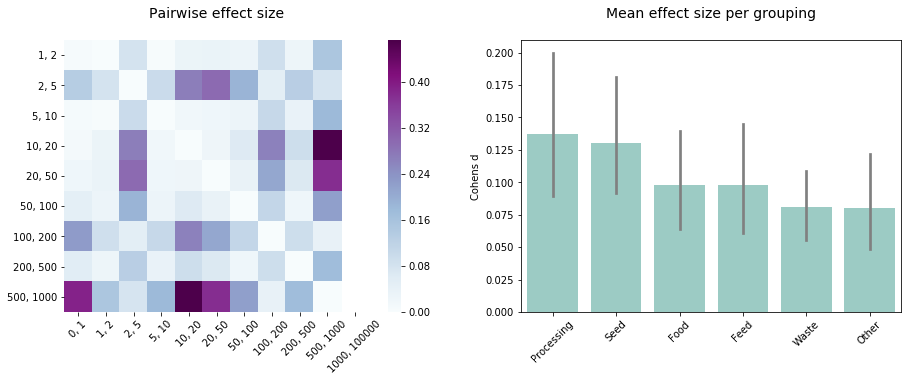

In [106]:
cohens_full_func(df, how='across')

<a name="FoodFeedOtherWithin"></a>
<h2>Food Feed Other within Farm Size Groups</h2><br>

This plot shows the percentage of Food, Feed, Seed, Waste, Processing, and Other for each farm size category. For example, {{one_food}} % of the crops produced for farms under 1 ha is food, while {{one_waste}}% of their crop production is waste.

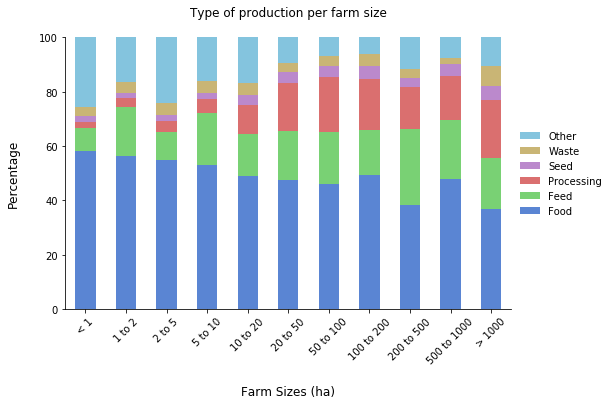

In [107]:
plot_stacked_bar(df_within, how='within', fig_=True)

In order to better understand whether there are differences within how a given farm size group allocates their crop production, these box plots show the total amount of crops produced (in logged kcal for standardization). As in the previous analysis, across all farm size categories there are no visual differences in the means and confidence intervals. But, there are many of outliers in each plot that indicate high variance.

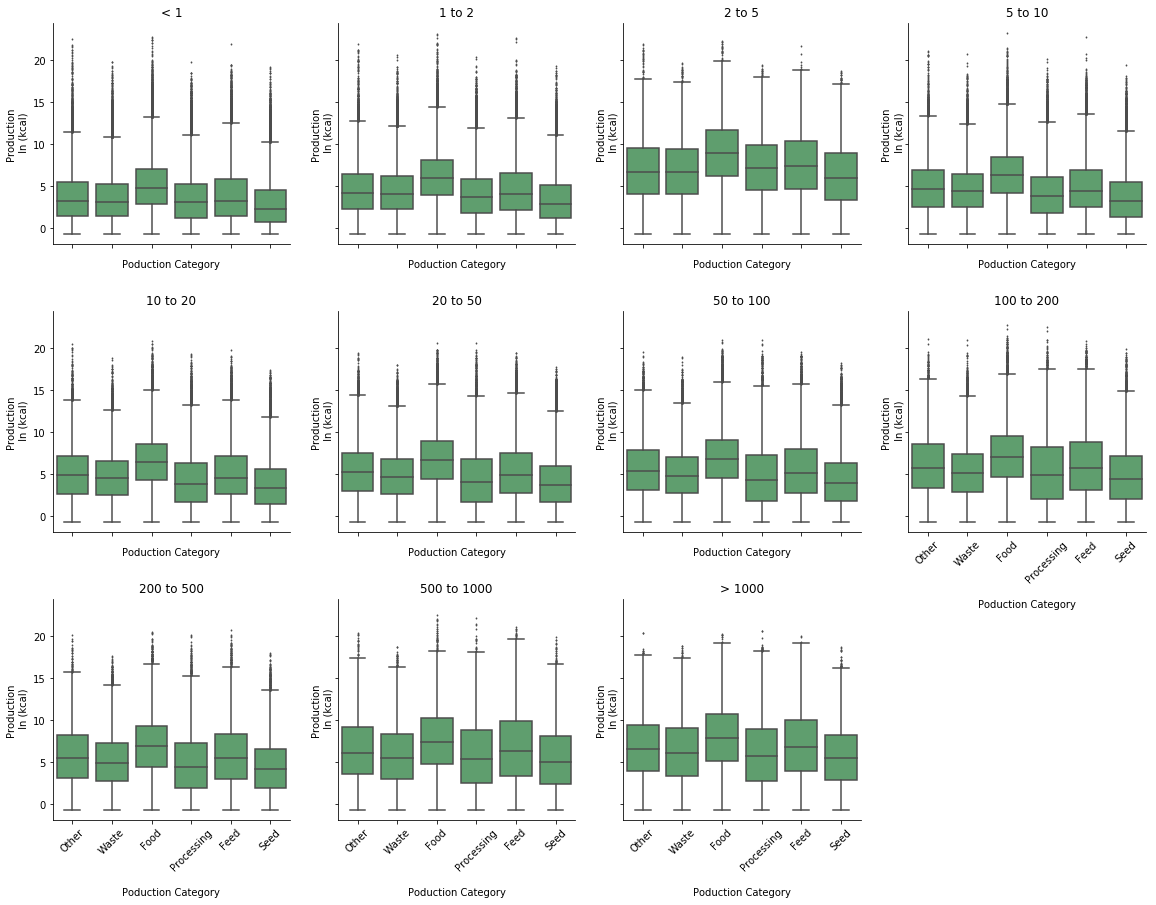

In [ ]:
factor_plot(df, id_var='variable')

Since many of the plots have large variance and skewness, here are density plots comparing farm size classes per each category. We can see that the largest farm size group has different distributions from the remaining groups.

In [ ]:
tmp = df.copy()

if use_predicted is False:

    fs = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
          '(10, 20]', '(20, 50]', '(50, 100]', 
          '(100, 200]', '(200, 500]', '(500, 1000]', 
          '(1000, 100000]']

else:
    
    fs = ['(0, 2]', '(2, 5]', '(5, 10]', 
          '(10, 20]', '(20, 50]', '(50, 100]', 
          '(100, 100000]']

    
tmp = tmp.dropna()
cols = tmp.columns

cmap = cm.get_cmap('viridis', 7)    # Set3 and YlGnBu are used throughout
colors_ = []

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors_.append(colors.rgb2hex(rgb))


fig = plt.figure(figsize=[20,15])

for j in xrange(len(fs)):
    
    tmp1 = tmp.loc[tmp['Farm_Sizes'] == fs[j]]

    ax = fig.add_subplot(4, 4, j+1)
    ax.set_axis_bgcolor("#d6d7e5")
    ax.grid(alpha=0.0)

    for i in xrange(1, len(cols)):
        np.log(tmp1[cols[i]]).plot(kind='kde', 
                                   label=cols[i],
                                   color=colors_[i],
                                   linewidth=2,
                                   ax=ax)
    
    ax.set_title(fs[j][1:-1] + ' ha', fontsize=16)
    ax.set_ylabel('Density', fontsize=14)


legend = ax.legend(frameon=True, fontsize=12)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::-1], labels[::-1],
                   loc='center left',
                   frameon=1,
                   bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

We calculated the effect size for the differences within each farm size group, but across production categories (e.g., food, feed, other).
There were only medium differences in effect size when looking at how each farm size group allocated their production. Most of the differences were between food and the other categories. Below is a heatmap (left) of the Cohen's D per each farm size class pair, where darker purple indicates a greater effect size. The chart to the right shows the effect size estimates for each production category; the error bars indicate the spread of effect sizes for every farm size class pair.

In [ ]:
cohens_full_func(df, how='within')

### Putting across and within findings together

In [ ]:
tmp = df_across.reindex().transpose().loc[:,['Food', 'Feed', 'Processing', 'Other', 'Seed', 'Waste']]
tmp2 = df_within.loc[:,['Food', 'Feed', 'Processing', 'Other', 'Seed', 'Waste']]
tmp3 = 100 * tmp * tmp2

fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
tmp3.plot(kind='bar',
          stacked=True,
          cmap=ListedColormap(sns.color_palette('muted', n_colors=6).as_hex()),
          alpha=0.9,
          linewidth=0,
          grid=False,
          ax=ax)


ax.set_xticklabels([x.get_text()[1:-1] for x in ax.get_xticklabels()], rotation=45)
ax.set_yticks(np.arange(0, 21, 3))
ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_title('Production type across farm sizes\n', fontsize=20)
ax.set_xlabel('Farm Size (ha)', fontsize=18)
ax.set_ylabel('Percentage\n', fontsize=18)
h,l = ax.get_legend_handles_labels()
h = reversed(h)
l = reversed(l)
ax.legend(h, l, frameon=False, loc=[0.9, 0.6], fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('/Users/Vinny_Ricciardi/Desktop/ffo_all.png', dpi=1000, bbox_inches='tight')

plt.show()

<a name="GlobalEstimates"></a>
<h2>Global Estimates</h2><br>

To construct a global estimate based on our sample, we first resampled using the Jacknife and bootstrapping techniques.

**Jacknife:**
We calculated the total food production while iteratively subsetting each country. Then we take the mean and confidence intervals for each farm size class. The Jacknife resampling technique allows us to understand the error and bias in our results and construct confidence intervals around that bias.

**Bootstrap:**
To achieve 95% confidence intervals around our sample estimates, we bootstrapped the data with the accelerated bias-corrected percentile limits method for 1000 iterations. This bootstrapping method is non-parametric and uses the proportion of resampled values that fall above the non-resampled mean to estimate the population distribution (Manly, 2006)⁠. The natural log of food production was used for the bootstrap procedure, since the distribution was near log-normal.

**Main difference:**
The Jacknife resulted in narrower confidence intervals mainly because of the variable's distribution, hence the non-parametric bootstrapping method used (accelerated bias-corrected percentile limits method) to give more conservative estimates on production ranges per farm size class and to account for any non-normal distributions.

<a name="Jacknife"></a>
<h3>Jacknife Estimates Across Farm Sizes</h3>

In [ ]:
# For this section, any time there is 'Food' in a variable it was replaced with
# Feed, Processing, Seed, or Other to calculate the appropriate values.
# For this section the predicted values can be incoprpoated via the 'use_predicted' variable
# that is set in the begining of this notebook. This can be directly set in this section if needed
# by decalring a new 'use_predicted' as True/False here.

def jacknife_prep(path, how='under1', use_predicted=use_predicted, 
                  predict_how=None, variable='production_Food_kcal', region=None):
    
    try:
        fao_regions = pd.read_csv('/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/FAO_FoodBalance/FAO_regional_lookup.csv')
    except:
        fao_regions = pd.read_csv('/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/FAO_FoodBalance/FAO_regional_lookup.csv')
    
    if use_predicted is False:
        
        data = pd.read_csv(PATH, low_memory=False)
        data['fs_class_max'] = np.where(data['fs_class_max'].isnull(), 10000, data['fs_class_max'])
        data['production_kcal'] = data['Production_fix']
        data = data.replace(0.0, np.nan)  # there were many zero values
        
        if region is not None:
            
            data = pd.merge(data, fao_regions, left_on='NAME_0', right_on='Country', how='inner')
            data = data.loc[data['Country Group'] == region]
            
        else:
            pass
        
            
        if how is 'under2':

            data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                        bins=[0, 2, 5, 10, 20, 50,
                                              100, 200, 500, 1000, 100000])

            fs_order = ['(0, 2]', '(2, 5]', '(5, 10]', '(10, 20]', 
                        '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
                        '(500, 1000]', '(1000, 100000]']

            fs_txt = ['< 2', '2 to 5', '5 to 10', '10 to 20',
                      '20 to 50', '50 to 100', '100 to 200', '200 to 500',
                      '500 to 1000', '> 1000']

        else:

            data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                            bins=[0, 1, 2, 5, 10, 20, 50,
                                                  100, 200, 500, 1000, 100000])

            fs_order = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
                        '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
                        '(500, 1000]', '(1000, 100000]']

            fs_txt = ['< 1', '1 to 2', '2 to 5', '5 to 10', '10 to 20',
                      '20 to 50', '50 to 100', '100 to 200', '200 to 500',
                      '500 to 1000', '> 1000']

    else:
        
        if predict_how is None:
            
            "Need predict_how when using predicted values: 'means', 'actual'"
            
        elif predict_how is 'actual':
            
            data = read_data_init(PATH, use_predicted=True)
            
            if region is not None:
                
                data = pd.merge(data, fao_regions, left_on='NAME_0', right_on='Country', how='inner')
                data = data.loc[data['Country Group'] == region]

            else:
                pass

        
        else:

            data = join_predicted(PATH, 
                                  use_predicted=True, 
                                  predict_how=predict_how)
            
            if region is not None:
            
                data = pd.merge(data, fao_regions, left_on='NAME_0', right_on='Country', how='inner')
                data = data.loc[data['Country Group'] == region]

            else:
                pass


        fs_order = ['(0, 2]', '(2, 5]', '(5, 10]', 
                    '(10, 20]', '(20, 50]', '(50, 100]', '(100, 100000]']

        fs_txt = ['< 2','2 to 5', '5 to 10', '10 to 20',
                  '20 to 50', '50 to 100', '> 100']

    if type(variable) is str:

        variables = ['NAME_0', 'Farm_Sizes', variable]
    
    else:
        variables = ['NAME_0', 'Farm_Sizes'] + variable
    
    data['Farm_Sizes'] = data['Farm_Sizes'].astype(str)
    data = data.loc[:, variables]
    data = data.dropna()
    
    return data, fs_order, fs_txt

In [ ]:
data, fs_order, fs_txt = jacknife_prep(PATH, how='under1', 
                                       use_predicted=use_predicted, predict_how='means',
                                       variable='production_Food_kcal')

In [ ]:
def jacknife(data, variable='production_Food_kcal'):
    
    dictionary = dict(zip(fs_order, range(0, len(fs_order))))  # used to circumvent categorical indexing
    data['ix'] = data['Farm_Sizes'].map(dictionary)

    out = pd.DataFrame(columns=['NAME_0', 'Farm_Sizes', 'ix'])
    
    fsize = []
    ixs = []

    for f, ix in zip(data['Farm_Sizes'].unique(), data['ix'].unique()):
        
        out2 = pd.DataFrame(columns=['NAME_0', 'Farm_Sizes', 'ix'])

        tmp = data.loc[data['Farm_Sizes'] == f]

        tmp = tmp.sort_values('ix')
        
        names = []
        
        for i in tmp.NAME_0.unique():
            
            tmp2 = tmp[tmp['NAME_0'] != i]

            pivot = pd.pivot_table(tmp2, 
                                   index=['ix'],
                                   values=variable, 
                                   aggfunc=np.nansum).reset_index()

            pivot['NAME_0'] = i
            pivot['Farm_Sizes'] = f
            pivot['ix'] = ix
            out2 = pd.concat([out2, pivot])
            
        out2['tot_mean'] = np.nanmean(out2[variable])
        out2['mj_m_2'] = (out2[variable] - out2['tot_mean'])**2
        out2['s'] = np.sqrt(np.nansum(out2['mj_m_2']) / float(len(tmp.NAME_0.unique()) - 1))
        out2['se'] = out2['s'] / np.sqrt(len(tmp.NAME_0.unique()) - 1)
        out2['ci_high'] = out2['tot_mean'] + (2.09 * out2['se'])  # 2.09 is the upper 0.25% of the t-distribution
        out2['ci_low'] = out2['tot_mean'] - (2.09 * out2['se'])
        
        out = pd.concat([out, out2])
    
        out['country_mean'] = out[variable]
    
    out = out.drop(variable, 1)
    out['country_mean_p'] = (out['country_mean'] / data[variable].sum())
    out['country_ci_high_p'] = out['country_mean_p'] * np.mean(out['ci_high']/ out['tot_mean'])
    out['country_ci_low_p'] = out['country_mean_p'] * np.mean(out['ci_low']/ out['tot_mean'])
    out['fs_mean_p'] = (out['tot_mean'] / data[variable].sum())
    out['fs_ci_high_p'] = out['fs_mean_p'] * np.mean(out['ci_high']/ out['tot_mean'])
    out['fs_ci_low_p'] = out['fs_mean_p'] * np.mean(out['ci_low']/ out['tot_mean'])
    
    pivot = pd.pivot_table(out,
                          index=['Farm_Sizes', 'ix'],
                          values=['fs_mean_p', 'fs_ci_high_p', 'fs_ci_low_p']).reset_index()

    pivot.columns = ['Farm_Sizes', 'ix', 'ci_high', 'ci_low', 'mean']

    return out, pivot

In [ ]:
df_jk, prods = jacknife(data, variable='production_Food_kcal')

This chart shows the results of the Jacknife sample. Each bar represents the range of food production by each farm size class.

In [ ]:
def barplot_resample(data, title_insert='jacknife', ax=None, ffo_type='food'):
    
    prods = data.sort_values('ix')
    yerr = np.c_[prods['mean'] - prods['ci_low'], prods['ci_high'] - prods['mean']].T

    if ax is None:
        fig = plt.figure(figsize=[10, 7])
        ax = fig.add_subplot(111)
    
    else:
        ax = ax
    
    ax.bar(range(len(prods['mean'])), 100*prods['mean'], 
            yerr=100*yerr,
            color='#5C87D0',  # sns.color_palette('BuPu', 11)[-1],
            error_kw=dict(ecolor='k',  #'gray', 
                          lw=4, 
                          capsize=2, 
                          capthick=1))

    ax.set_axis_bgcolor("#ffffff")
    ax.grid(alpha=0.0)
    ax.set_xticks(range(len(prods['mean'])))
    ax.set_xticklabels(fs_txt, rotation=45)
    ax.set_xlabel('Farm Sizes (ha)\n', fontsize=18)
    ax.set_ylabel('Percentage\n'.format(ffo_type.lower()), fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_title('Percent of {} (kcal) produced per farm size'.format(ffo_type.lower()), fontsize=20)
#                  '\nwith {} upper and lower bounds\n'.format(ffo_type.lower(), title_insert))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    fig.savefig("/Users/Vinny_Ricciardi/Desktop/food_cumul.png",
                dpi=1000,
                bbox_inches='tight', 
                transparent=True)
    if ax is None:
        plt.show()
    
    else:
        return ax
    
    
barplot_resample(prods, title_insert='jacknife');

In [ ]:
# def plot_ranges(data, variable='country_mean_p',
#                 title='Jacknife distributions \nacross farm size classes\n'):

#     fig = plt.figure(figsize=[8, 5])
#     # fs = prods['Farm_Sizes'].unique()
#     # fs = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
#     #       '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
#     #       '(500, 1000]', '(1000, 100000]']

#     fs = ['(0, 2]', '(2, 5]', '(5, 10]', 
#           '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
#           '(500, 1000]', '(1000, 100000]']

#     colors_ = ['#97d6b9',
#               '#73c8bd',
#               '#52bcc2',
#               '#37acc3',
#               '#2498c1',
#               '#1f80b8',
#               '#2165ab',
#               '#234da0',
#               '#253795',
#               '#172978',
#               '#081d58'] 

#     ax = fig.add_subplot(111)

#     for i in xrange(len(fs[:])): 
#         tmp = prods[prods['Farm_Sizes'] == fs[i]]
#         label = fs[i][1:-1]
#         tmp[variable].plot(kind='kde', label=label, color=colors_[i], ax=ax)

#     legend = ax.legend(frameon=True, fontsize=12, loc='upper right')
#     frame = legend.get_frame()
#     frame.set_color('#d6d7e5')
#     ax.set_axis_bgcolor("#d6d7e5")
#     ax.grid(alpha=0.0)
#     ax.set_clip_on(False)
#     ax.tick_params(axis='x', labelsize=12)
#     ax.tick_params(axis='y', labelsize=12)
#     ax.set_xlabel('\nFood Production (% kcal)', fontsize=12)
#     ax.set_title(title, fontsize=14)
#     fig.tight_layout()
    
#     return plt.show()

In [ ]:
# prods = df_jk.copy()
# plot_ranges(prods, variable='country_mean_p', title='Jacknife distributions \nacross farm size classes\n')

<a name="Boostrap"></a>
<h3>Bootstrap Estimates Across Farm Sizes</h3>

In [ ]:
def bootstrap_results(data, method='bca', how='noncumulative', variable='production_Food_kcal'):

    out = pd.DataFrame(columns=['Farm_Sizes', 'mean', 'ci_low', 'ci_high'])
    dictionary = dict(zip(fs_order, range(0, len(fs_order))))  
    data['ix'] = data['Farm_Sizes'].map(dictionary)
    data = data.sort_values('ix')

    for f in data['Farm_Sizes'].unique():

        farms = []
        lows = []
        highs = []
        means = []

        tmp = data.loc[data['Farm_Sizes'] == f]
        pivot = pd.pivot_table(tmp, 
                               index=['NAME_0'],
                               values=variable, 
                               aggfunc=np.nansum).reset_index()
        arr = np.log(np.array(pivot[variable]))

        l, h = bootstrap.ci(arr, statfunction=np.nanmedian, alpha=0.05, n_samples=10000,
               method=method, output='lowhigh', epsilon=0.001, multi=False,
               _iter=True)
        
        if how is 'cumulative':

            if f is data['Farm_Sizes'].unique()[0]:
                fs_m = np.nansum(np.exp(arr)) / np.nansum(data[variable])
            else:
                fs_m = fs_m + (np.nansum(np.exp(arr)) / np.nansum(data[variable]))

        else:
            fs_m = np.nansum(np.exp(arr)) / np.nansum(data[variable])
            
        low = fs_m - (l / np.nansum(arr))
        high = fs_m + (h / np.nansum(arr))

        lows.append(low)
        highs.append(high)
        farms.append(f)
        means.append(fs_m)

        out_t = pd.concat([pd.DataFrame(farms, columns=['Farm_Sizes']),
                           pd.DataFrame(lows, columns=['ci_low']),
                           pd.DataFrame(highs, columns=['ci_high']),
                           pd.DataFrame(means, columns=['mean'])], axis=1)
        out = pd.concat([out, out_t], axis=0)


    out['ix'] = out['Farm_Sizes'].map(dictionary)
    out['ci_low'] = np.where(out['ci_low'] < 0., 0., out['ci_low'])

    return out

In [ ]:
prods = bootstrap_results(data, how='noncumulative')
barplot_resample(prods, title_insert='bootstrap');

The bootstrap was calculated using the accelerated bias-corrected percentile limits method. Basically, this bootstrapping method is non-parametric and uses the proportion of resampled values that fall above the non-resampled mean to estimate the population distribution. Here, I used the natural log of the value before running the bootstrap procedure, since the distribution was near log-normal; without this transformation the confidence intervals were systematically shifted upwards. With the transformation they are now centered around the mean. The table below, shows each cumulative bootstrapped result.

In [ ]:
prods_cumulative = bootstrap_results(data, how='cumulative')
barplot_resample(prods_cumulative, title_insert='bootstrap');

In [ ]:
prods_cumulative

In [ ]:
# Variables that feed into dynamic abstract at top of notebook

if use_predicted is False:
    under2_low = round(100 * prods_cumulative.iloc[1, 2], 2)
    under2_high = round(100 * prods_cumulative.iloc[1, 1], 2)
else:
    under2_low = round(100 * prods_cumulative.iloc[0, 2], 2)
    under2_high = round(100 * prods_cumulative.iloc[0, 1], 2)

#### Actual - All types within Farm Sizes

Here we calculate the within farm size group bootstrap estimates using the same method as above.

In [ ]:
def bootstrap_results_within(data, 
                             method='bca', 
                             how='noncumulative', 
                             variable='production_Food_kcal'):

    out = pd.DataFrame(columns=['Farm_Sizes', 'mean', 'ci_low', 'ci_high'])
    dictionary = dict(zip(fs_order, range(0, len(fs_order))))  
    data['ix'] = data['Farm_Sizes'].map(dictionary)
    data = data.sort_values('ix')

    for f in data['Farm_Sizes'].unique():

        farms = []
        lows = []
        highs = []
        means = []

        tmp = data.loc[data['Farm_Sizes'] == f]
        pivot = pd.pivot_table(tmp, 
                                index=['NAME_0'],
                                values=variable, 
                                aggfunc=np.nansum).reset_index()

        arr = np.log(np.array(pivot[variable]))

        l, h = bootstrap.ci(arr, statfunction=np.nanmedian, alpha=0.05, n_samples=10000,
               method=method, output='lowhigh', epsilon=0.001, multi=False,
               _iter=True)
        
        if how is 'cumulative':

            if f is data['Farm_Sizes'].unique()[0]:
                fs_m = np.nansum(np.exp(arr)) / np.nansum(data[variable])
            else:
                fs_m = fs_m + (np.nansum(np.exp(arr)) / np.nansum(data[variable]))

        else:
            
            pivot1 = pd.pivot_table(tmp, 
                                    index=['NAME_0'],
                                    values=['production_Feed_kcal',
                                            'production_Food_kcal',
                                            'production_Processing_kcal',
                                            'production_Seed_kcal',
                                            'production_Waste_kcal',
                                            'production_Other_kcal'],
                                    aggfunc=np.nansum).reset_index()

            pivot1['value'] = pivot1.iloc[:, 1:].sum(axis=1)

            pivot = pd.merge(pivot, pivot1, on=['NAME_0', variable], how='inner')
            
            fs_m = np.nansum(np.exp(arr)) / np.nansum(pivot['value'])
            
        low = fs_m - (l / np.nansum(arr))
        high = fs_m + (h / np.nansum(arr))

        lows.append(low)
        highs.append(high)
        farms.append(f)
        means.append(fs_m)

        out_t = pd.concat([pd.DataFrame(farms, columns=['Farm_Sizes']),
                           pd.DataFrame(lows, columns=['ci_low']),
                           pd.DataFrame(highs, columns=['ci_high']),
                           pd.DataFrame(means, columns=['mean'])], axis=1)
        out = pd.concat([out, out_t], axis=0)


    out['ix'] = out['Farm_Sizes'].map(dictionary)
    out['ci_low'] = np.where(out['ci_low'] < 0., 0., out['ci_low'])

    return out

In [ ]:
data, fs_order, fs_txt = jacknife_prep(PATH, how='under2', 
                                       use_predicted=use_predicted, 
                                       predict_how='means',
                                       variable=['production_Feed_kcal', 
                                                 'production_Food_kcal',
                                                 'production_Processing_kcal',
                                                 'production_Seed_kcal',
                                                 'production_Waste_kcal',
                                                 'production_Other_kcal'])

In [ ]:
for i in ['Feed', 'Food', 'Processing', 'Seed', 'Waste', 'Other']:
    tmp = bootstrap_results_within(data, 
                                   method='bca', 
                                   how='noncumulative', 
                                   variable='production_{}_kcal'.format(i))
    tmp['type'] = i
    
    if i is 'Feed':
        out = tmp.copy()
    else:
        out = pd.concat([out, tmp], axis=0)

In [ ]:
fig = plt.figure(figsize=[15, 10])
ts = ['Food', 'Feed', 'Processing', 'Seed', 'Waste', 'Other']

# ts= ['Processing', 'Waste', 'Food']
# colors = ['#A1DEE8', '#A591DB', '#908946']
# ax = fig.add_subplot(111)
for i in xrange(len(ts)):
    ax = fig.add_subplot(2, 3, i+1)
    t = out.loc[out['type'] == ts[i]]
    ax.plot(t['ix'], 100*t['mean'], color=sns.color_palette('muted', len(ts))[i], linewidth=7, label=ts[i])
    ax.fill_between(t['ix'], 100*t['ci_low'], 100*t['ci_high'], color='grey', alpha=0.2)
    ax.set_title(ts[i], fontsize=12)
    ax.set_ylabel('Percent', fontsize=12)
    ax.set_xlabel('Farm Size (ha)', fontsize=12)
    ax.set_xticks(np.arange(len(fs_order)))
    ax.set_xticklabels([x[1:-1] for x in fs_order], rotation=45)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# ax.legend()    
fig.tight_layout()
plt.show()

###### Regional analysis on production category within farm sizes

We test for regional differences in the production type analysis within each farm size group.
Due to small sample sizes per region, results may be unstable using the bootstrap method and this is only used as a check for potential regional differences. It is not conclusive.

In [ ]:
warnings.filterwarnings('ignore')

regions = ['Africa', 
           'Australia & New Zealand', 
           'Asia', 
           'Central America', 
           'Europe', 
           'Northern America', 
           'Oceania', 
           'South America']

fig = plt.figure(figsize=[15, 10])

for region in xrange(len(regions)):
    
    data, fs_order, fs_txt = jacknife_prep(PATH, how='under2', 
                                           use_predicted=True, predict_how='means',
                                           variable=['production_Feed_kcal', 
                                                     'production_Food_kcal',
                                                     'production_Processing_kcal',
                                                     'production_Seed_kcal',
                                                     'production_Waste_kcal',
                                                     'production_Other_kcal'],
                                          region=regions[region])

    
    t = bootstrap_results_within(data, 
                                 method='bca', 
                                 how='noncumulative', 
                                 variable='production_Food_kcal')
    
    ax = fig.add_subplot(3,3, region+1)
    
    ax.plot(t['ix'], 100*t['mean'], color='r')
    ax.fill_between(t['ix'], 100*t['ci_low'], 100*t['ci_high'], color='grey', alpha=0.2)
    ax.set_title(regions[region])
    ax.set_ylabel('Percent')
    ax.set_xlabel('Farm Size (ha)')
    ax.set_xticks(np.arange(len(fs_order)))
    ax.set_xticklabels([x[1:-1] for x in fs_order], rotation=45)

fig.tight_layout()
plt.show()
    

#### Actual and Predicted Together - All types Across Farm Sizes

Here we combine all the directly measured and predicted data to compare production type across farm sizes.

In [ ]:
def compile_predicted_actual(ffo_type='Food'):

    predict_dict = OrderedDict([('predict', [True, 'means']),
                                ('actual',  [True, 'actual'])])

    for key, value in predict_dict.iteritems():

        for i in xrange(1, len(value)):

            data, fs_order, fs_txt = jacknife_prep(PATH, 
                                                   how='under2', 
                                                   use_predicted=value[0], 
                                                   predict_how=value[i],
                                                   variable='production_{}_kcal'.format(ffo_type))

            df_jk, prods = jacknife(data, variable='production_{}_kcal'.format(ffo_type))
            
            prods = bootstrap_results(data, 
                                      how='noncumulative', 
                                      variable='production_{}_kcal'.format(ffo_type))
            prods['type'] = value[i]

            if value[i] is 'means':
                
                out = prods.copy()

            else:
                
                out = pd.concat([out, prods], axis=0)

    return out

In [ ]:
def group_predicted(data):

    data = pd.pivot_table(data,
                          index=['Farm_Sizes', 'ix'],
                          values=['ci_low', 'mean', 'ci_high'],
                          aggfunc=[np.min, np.mean, np.max]).reset_index()
    
    data = pd.concat([pd.DataFrame(data['Farm_Sizes']),
                      pd.DataFrame(data['ix']),
                      pd.DataFrame(data['amin']['ci_low']),
                      pd.DataFrame(data['mean']['mean']),
                      pd.DataFrame(data['amax']['ci_high'])],
                      axis=1)

    data_cs = data.copy()

    data_cs = data_cs.sort_values('ix')
    data_cs['mean_'] = np.cumsum(data_cs['mean'])
    data_cs['ci_low'] = (data_cs['mean_'] - 
                         (np.cumsum(data_cs['mean'] - data_cs['ci_low']) / (data_cs['ix'] + 1))) 
    data_cs['ci_high'] = ((np.cumsum(data_cs['ci_high'] - data_cs['mean']) / (data_cs['ix'] + 1)) +
                          data_cs['mean_'])
        
    data_cs['mean'] = np.cumsum(data_cs['mean'])

    return data, data_cs

In [ ]:
def plot_actual_predicted(data, ffo_type='Food'):

    out2 = data.loc[(data['type'] == 'means') | (data['type'] == 'actual')]
    together, together_cs = group_predicted(out2)

    out2 = data.loc[data['type'] == 'actual']
    actual, actual_cs = group_predicted(out2)
    
    fig = plt.figure(figsize=[15, 7])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    barplot_resample(actual_cs, title_insert='bootstrap', ffo_type=ffo_type, ax=ax1)
    barplot_resample(together_cs, title_insert='bootstrap', ffo_type=ffo_type, ax=ax2)
    ax1.set_title('Actual Values ONLY\n\n' + ax1.get_title())
    ax2.set_title('Actual AND Predicted Values\n\n' + ax2.get_title())
    ax1.set_ylim([0,1.19])
    ax2.set_ylim([0,1.19])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig.tight_layout()
    
    return plt.show()

In [ ]:
txt = ['Food', 'Feed', 'Processing', 'Seed', 'Waste', 'Other']
for i in txt:
    
    out1 = compile_predicted_actual(ffo_type=i)
    out1['type_ffo'] = i
    
    if i is 'Food':
        
        out = out1.copy()
        
    else:
        
        out = pd.concat([out, out1], axis=0)

In [ ]:
def prep_bar_actual_modeled(data):

#     data = data.sort_values(['type_ffo', 'ix'])
    data['ci_low'], data['ci_high'] = [data['mean'] - data['ci_low'], 
                                       data['ci_high'] - data['mean']]

    for i in xrange(0, len(data), 7):

        line = pd.DataFrame({'Farm_Sizes': np.nan, 
                             'ci_high': np.nan,
                             'ci_low': np.nan,
                             'mean': np.nan,
                             'ix': np.nan,
                             'type_ffo': np.nan}, index=[i])

        if i is 0:
            
            dd = data.reset_index(drop=True)
        
        elif i is not 42:
        
            dd = pd.concat([dd.ix[:i-1], line, dd.ix[i:]])

    dd = dd.reset_index(drop=True)
    dd = dd.reset_index()
    yerr = np.array([dd['ci_low'], dd['ci_high']])
    
    return dd, yerr

# out_all = pd.pivot_table(out, 
#                          index=['Farm_Sizes', 'ix', 'type_ffo'], 
#                          values=['ci_high', 'ci_low', 'mean'],
#                          aggfunc=np.nanmean).reset_index()

out_all = out.loc[out['type'] != 'actual']
out_all = out_all.drop('type', 1)

out_act = out.loc[out['type'] == 'actual']
out_act = out_act.drop('type', 1)

plt_all, yerr_all = prep_bar_actual_modeled(out_all)
plt_act, yerr_act = prep_bar_actual_modeled(out_act)

data_tmp, fs_order, fs_txt = jacknife_prep(PATH, how='under1', 
                                           use_predicted=True, predict_how='means',
                                           variable='production_Food_kcal')

In [ ]:
fig = plt.figure(figsize=[15, 7])
ax = fig.add_subplot(111)

# for d, y, a in zip([plt_all, plt_act], 
#                    [yerr_all, yerr_act],
#                    [0.2, 1]):
#     ax.bar(d['index'], d['mean'], 
#            yerr=y, 
#            color=sns.color_palette('YlGnBu', 7)*6,
#            edgecolor='grey',
#            error_kw=dict(ecolor='k', lw=2, alpha=0.7, capsize=5, capthick=0),
#            alpha=a)

ax.bar(plt_all['index'], plt_all['mean'], 
       yerr=yerr_all, 
       color=sns.color_palette('BuPu', 8)*6,
       edgecolor='grey',
       error_kw=dict(ecolor='k', lw=2, alpha=0.7, capsize=5, capthick=0),
       alpha=1)

ax.plot(plt_act['index'], plt_act['mean'],  # Makes a halo to highlight the actual values
        color='w',
        marker='s',
        markersize=8,
        linewidth=0,
        alpha=0.5)


ax.plot(plt_act['index'], plt_act['mean'], 
        color='k',
        marker='o',
        markersize=4,
        linewidth=0,
        alpha=0.5)


ax.errorbar(plt_act['index'], plt_act['mean'], yerr_act, 
            ecolor='k', 
            lw=0, 
            capsize=5, 
            capthick=2, 
            linestyle='',
            alpha=0.5)



h = []
line_ = lines.Line2D([], [], color='k',linestyle='', alpha=0.5,
                     linewidth=1, marker='', markersize=4)
h.append(line_)

for i in xrange(7):
    line_ = lines.Line2D([], [], color=sns.color_palette('BuPu', 7)[i], linewidth=10)
    h.append(line_)
    
line_ = lines.Line2D([], [], color='k',linestyle='', alpha=0.5,
                     linewidth=1, marker='', markersize=4)
h.append(line_)

line_ = lines.Line2D([], [], color='k',linestyle='', alpha=0.5,
                     linewidth=1, marker='o', markersize=4)
h.append(line_)

line_ = lines.Line2D([], [], color='k',linestyle='', alpha=0.5,
                     linewidth=1, marker="$%s$" % u'\u268C')
h.append(line_)


labels=[x[1:-1] for x in [' Including predicted data\n '] + fs_order + 
                         [' \n\nActual data\n ', ' Median ', ' Error ']]

ax.set_xticks(range(3, len(plt_act), 8))
ax.set_xticklabels(txt + [np.nan*8])
ax.set_ylabel('Percent]n', fontsize=12)
vals = ax.get_yticks()
ax.set_yticklabels(['{}'.format(int(x*100)) for x in vals], fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(handles=h, labels=labels,
         loc='center left',
         borderpad=2,
         ncol=1,
         frameon=0,
         bbox_to_anchor=(1, .5))

fig.savefig("/Users/Vinny_Ricciardi/Desktop/predicted.png",
           dpi=1000,
           transparent=True,
           bbox_inches='tight')
plt.show()

The above plot shows each farm size's percentage of production across food, feed, processing, seed, waste, and other categories. The shades of blues to purple indicate farm sizes. The bars are the predicted and actual (our dataset) values combined, while the gray dots indicate the actual values only; the vertical black lines and horizontal gray lines are the confidence intervals for each.

In [ ]:
data_orig = join_predicted(PATH, 
                           use_predicted=True, 
                           predict_how='means')

df2 = clean_data(data_orig)

df_within2 = perc(df2, how='within')
df_across2 = perc(df2, how='across')
df_cumsum2 = perc(df2, how='cumsum')

In [ ]:
tmp = df_across.reindex().transpose().loc[:,['Food', 'Feed', 'Processing', 'Other', 'Seed', 'Waste']]
tmp2 = df_within.loc[:,['Food', 'Feed', 'Processing', 'Other', 'Seed', 'Waste']]
tmp3 = 100 * tmp * tmp2
tmp3 = tmp3.reset_index()
tmp3['Farm_Sizes'] = tmp3['Farm_Sizes'].astype(str)
tmp3 = tmp3.set_index('Farm_Sizes').transpose()

tmp3['(0, 2]'] = tmp3.iloc[:, :2].sum(axis=1)
tmp3['(100, 100000]'] = tmp3.iloc[:, -5:-1].sum(axis=1)
tmp3 = tmp3.iloc[:, [11,2,3,4,5,6,-1]].transpose()

In [ ]:
tmp = df_across.reindex().transpose().loc[:,['Food', 'Feed', 'Processing', 'Other', 'Seed', 'Waste']]
tmp2 = df_within.loc[:,['Food', 'Feed', 'Processing', 'Other', 'Seed', 'Waste']]
tmp3 = 100 * tmp * tmp2
tmp3 = tmp3.reset_index()
tmp3['Farm_Sizes'] = tmp3['Farm_Sizes'].astype(str)
tmp3 = tmp3.set_index('Farm_Sizes').transpose()

tmp3['(0, 2]'] = tmp3.iloc[:, :2].sum(axis=1)
tmp3['(100, 100000]'] = tmp3.iloc[:, -5:-1].sum(axis=1)
tmp3 = tmp3.iloc[:, [11,2,3,4,5,6,-1]].transpose()

fig = plt.figure(figsize=[15,6])
ax1 = fig.add_subplot(131)
tmp3.plot(kind='bar',
          stacked=True,
          cmap=ListedColormap(sns.color_palette('muted', n_colors=6).as_hex()),
          alpha=0.9,
          linewidth=0,
          grid=False,
          legend=False,
          ax=ax1)

ax1.set_xticklabels([x.get_text()[1:-1] for x in ax1.get_xticklabels()], rotation=45)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel('Farm Size (ha)', fontsize=14)
ax1.set_ylabel('Percentage\n', fontsize=14)
ax1.set_title('Type of production per farm sizes\nUsing directly measured data\n', fontsize=14)
ax1.set_yticks(np.arange(0,60,10))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


tmp = df_across2.reindex().transpose().loc[:,['Food', 'Feed', 'Processing', 'Other', 'Seed', 'Waste']]
tmp2 = df_within2.loc[:,['Food', 'Feed', 'Processing', 'Other', 'Seed', 'Waste']]
tmp4 = 100 * tmp * tmp2
ax2 = fig.add_subplot(132)
tmp4.plot(kind='bar',
          stacked=True,
          cmap=ListedColormap(sns.color_palette('muted', n_colors=6).as_hex()),
          alpha=0.9,
          linewidth=0,
          grid=False, 
          legend=False,
          ax=ax2)

ax2.set_xticklabels([x.get_text()[1:-1] for x in ax2.get_xticklabels()], rotation=45)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlabel('Farm Size (ha)', fontsize=14)
# ax2.set_ylabel('Percentage\n', fontsize=14)
ax2.set_title('Type of production per farm sizes\nUsing directly measured + predicted data\n', fontsize=14)
ax2.set_yticks(np.arange(0,60,10))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


ax3 = fig.add_subplot(133)
tmp5 = tmp3 - tmp4
tmp5.plot(kind='bar',
          stacked=True,
          cmap=ListedColormap(sns.color_palette('muted', n_colors=6).as_hex()),
          alpha=0.9,
          linewidth=0,
          grid=False,
          legend=True,
          ax=ax3)

ax3.set_xticklabels([x.get_text()[1:-1] for x in ax3.get_xticklabels()], rotation=45)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.set_xlabel('Farm Size (ha)', fontsize=14)
# ax3.set_ylabel('Percentage\n', fontsize=14)
ax3.set_title('Difference between directly measured and\n directly measured + predicted data\n', fontsize=14)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
h,l = ax1.get_legend_handles_labels()
h = reversed(h)
l = reversed(l)
ax3.legend(h, l, loc=[1.05, 0.4], frameon=False, fontsize=14);

fig.tight_layout()
fig.savefig('/Users/Vinny_Ricciardi/Desktop/actual_predicted_all.png', bbox_inches='tight')

plt.show()